# Getting started with T5X and DALI

This tutorial shows the basics of using DALI with [T5X](https://github.com/google-research/t5x). Full example on how to train a Vision Transformer on ImageNet dataset is hosted in [NVIDIA JAX-Toolbox repository](https://github.com/NVIDIA/JAX-Toolbox/tree/main/rosetta/rosetta/projects/vit). This tutorial explains the DALI part of the workflow used there in more detail.

If you have not done so already, we recommend you to start with the [Getting started with DALI and JAX tutorial](jax-getting_started.ipynb) first as it explains the basics of DALI and JAX integration.


### Prerequisites

This tutorial assumes that you have already installed DALI and JAX with GPU support. If you haven't done so, please follow the [DALI installation guide](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/installation.html) and [JAX installation guide](https://jax.readthedocs.io/en/latest/installation.html).

Test data used for this example can be found in [DALI Github page](https://github.com/NVIDIA/DALI/tree/main/docs/examples/data/images).


In [1]:
image_dir = "../../data/images"

### Peekable iterator for T5X

Peekable iterator is a dedicated data iterator for T5X. This iterator is compatible with [Common Loop Utils](https://github.com/google/CommonLoopUtils) and can be used as a data source for T5X models. 

The code below shows how to use DALI with T5X by usgin the peekable iterator. The iterator follows the same decorator API as the regular DALI iterator for JAX. If you want to learn more about it, please refer to the [DALI and JAX Getting started tutorial](jax-getting_started.ipynb).

In [2]:
import nvidia.dali.fn as fn
from nvidia.dali.plugin.jax.clu import peekable_data_iterator


@peekable_data_iterator(
    output_map=["images", "labels"], reader_name="image_reader"
)
def iterator_fn():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader")
    images = fn.decoders.image(jpegs, device="mixed")
    images = fn.resize(images, resize_x=128, resize_y=128)
    return images, labels


# iterator can be passed to T5X configuration as a data source
iterator = iterator_fn(batch_size=8)

In addition to regular `next` method for the iterator peekable iterator provides `peek` and `peek_async` methods that return the current batch without advancing the iterator. In the T5X framework this is used to warm up the iterator before the training loop starts. `peek` returns the current batch synchronously, while `peek_async` returns the current batch asynchronously by using Python future. The batch can by obtained from the future by calling `result` method.

In [3]:
peeked_batch = iterator.peek()

peeked_async_batch = (
    iterator.peek_async()
)  # returns a future to the current batch
peeked_async_batch = (
    peeked_async_batch.result()
)  # blocks until the batch is ready

batch = next(iterator)

We can confirm that the iterator works as expected by printing the batches. We expect them to be the same since `peek` and `peek_async` are not advancing the iterator.

Let's write a helper function to display the batch:

In [4]:
import matplotlib.pyplot as plt
from matplotlib import gridspec


def show_image(images):
    columns = 4
    rows = (images.shape[0] + 1) // (columns)
    plt.figure(figsize=(24, (24 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(images[j])

Regular batch:

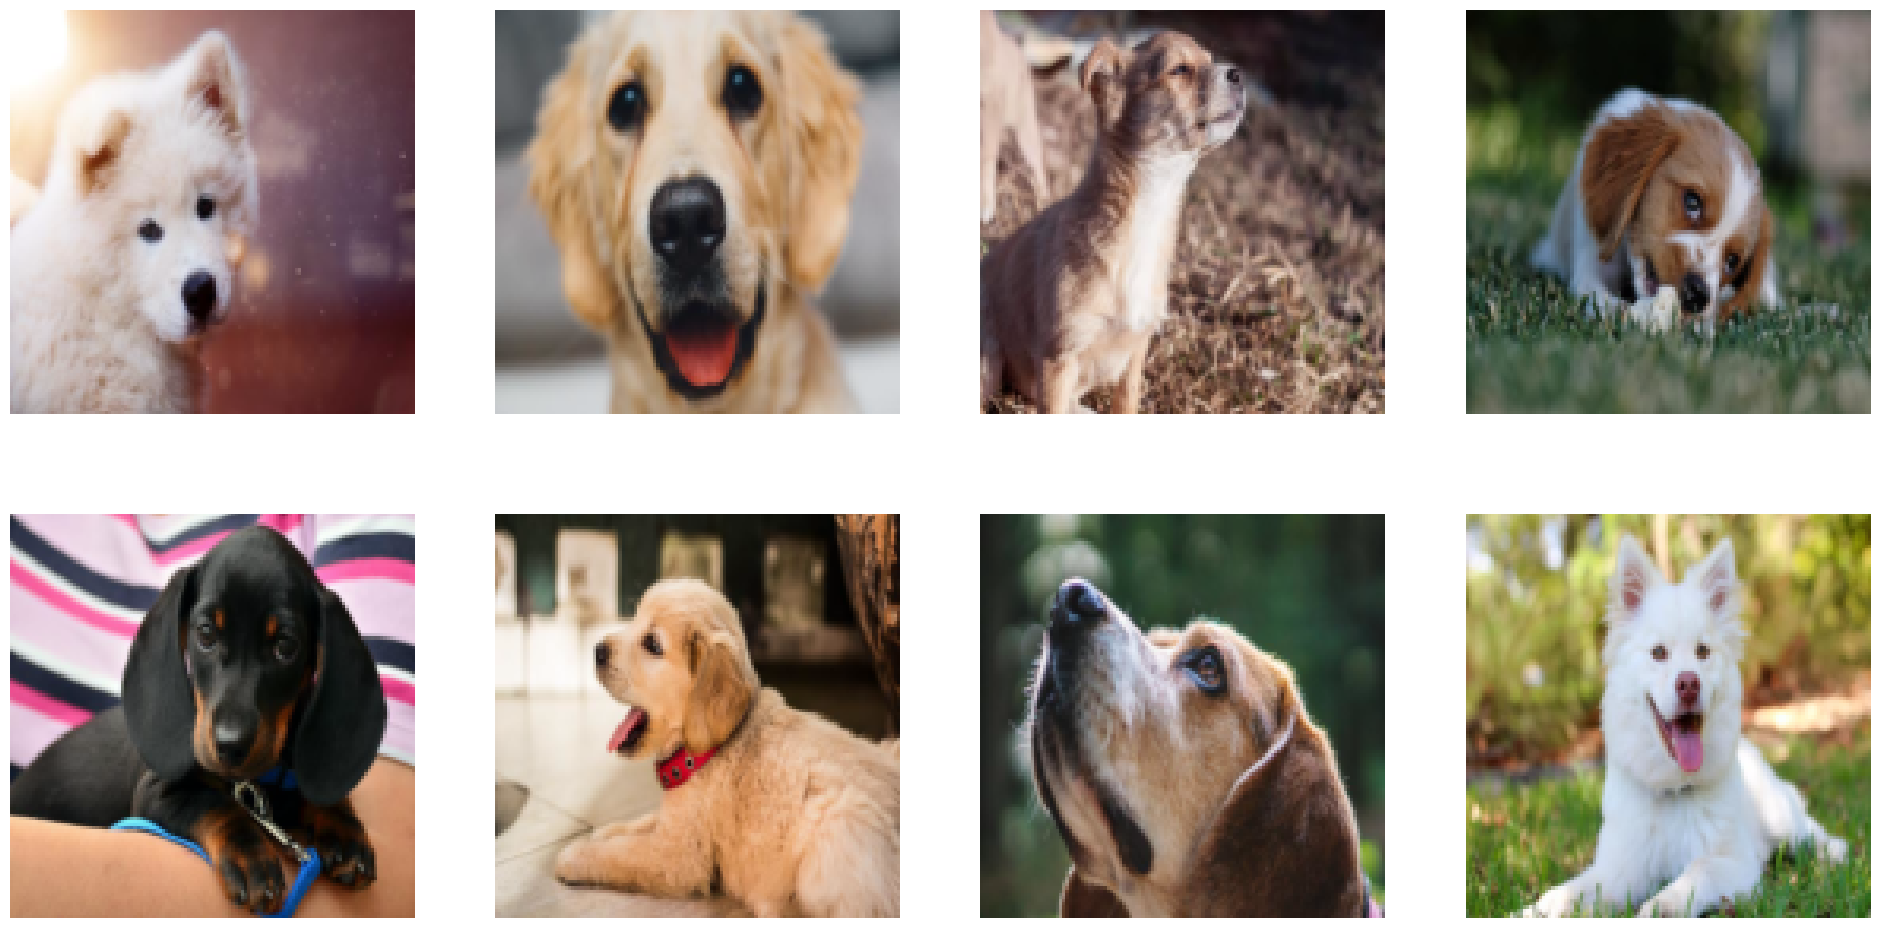

In [5]:
show_image(batch["images"])

Peeked batch:

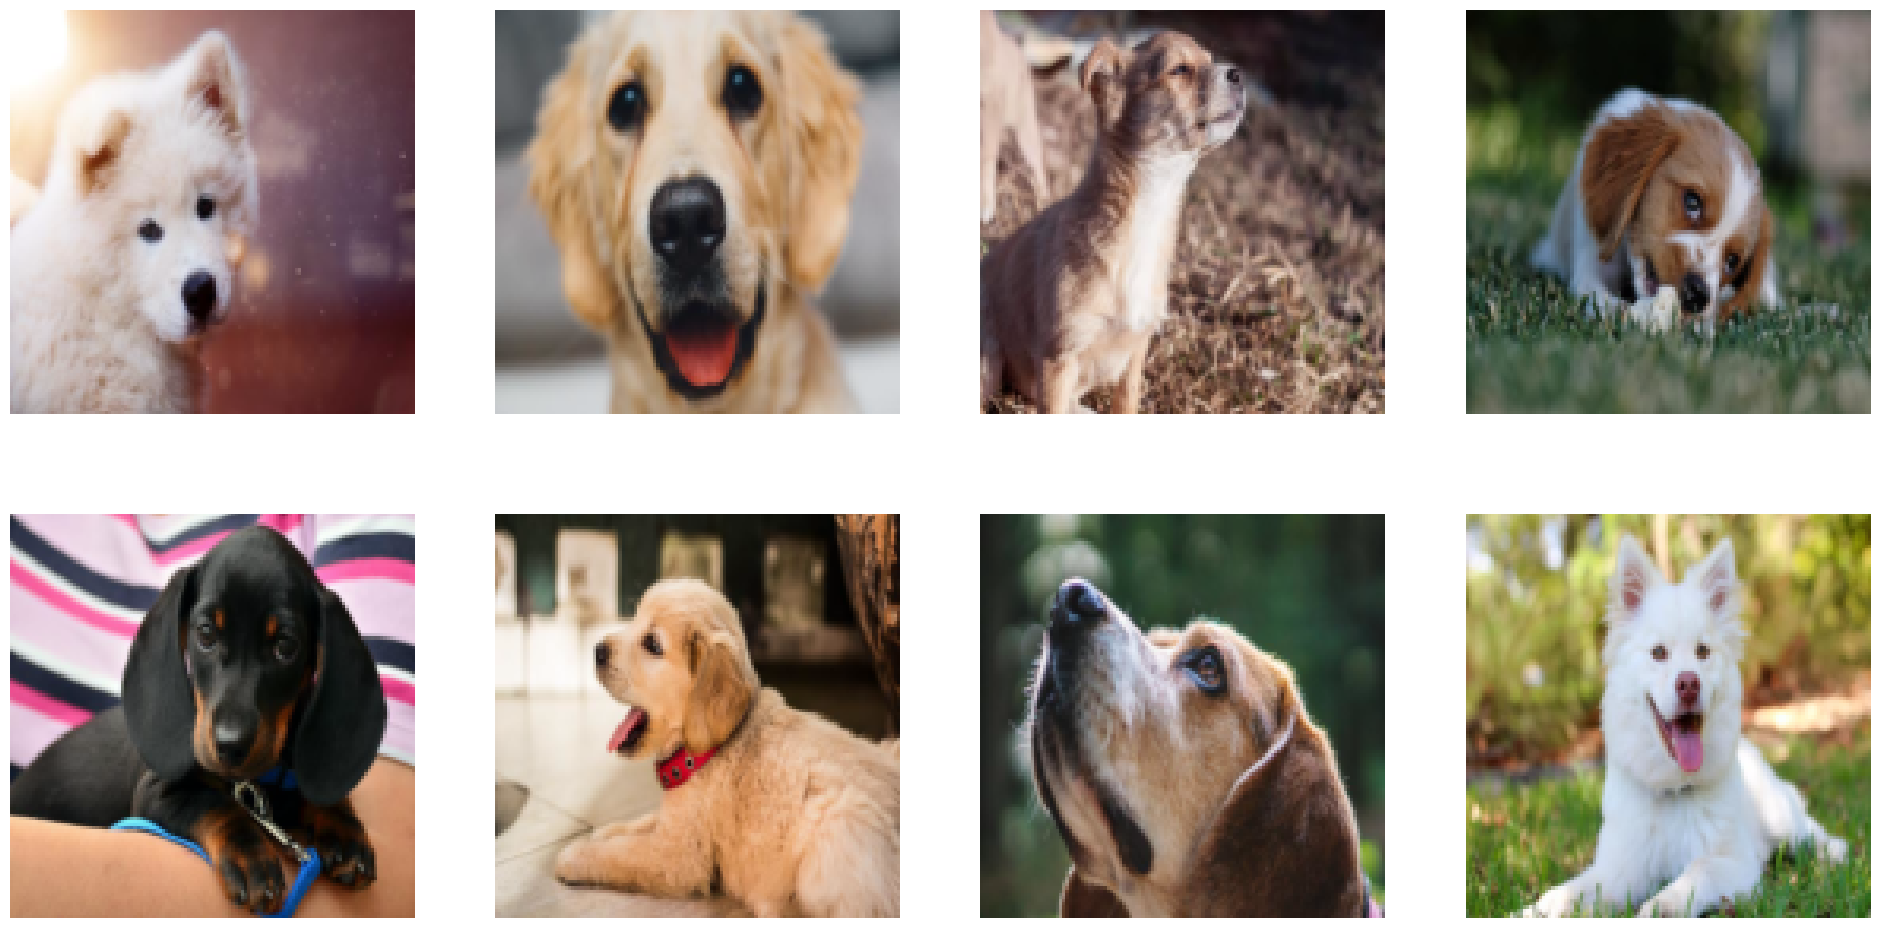

In [6]:
show_image(peeked_batch["images"])

Peeked async batch:

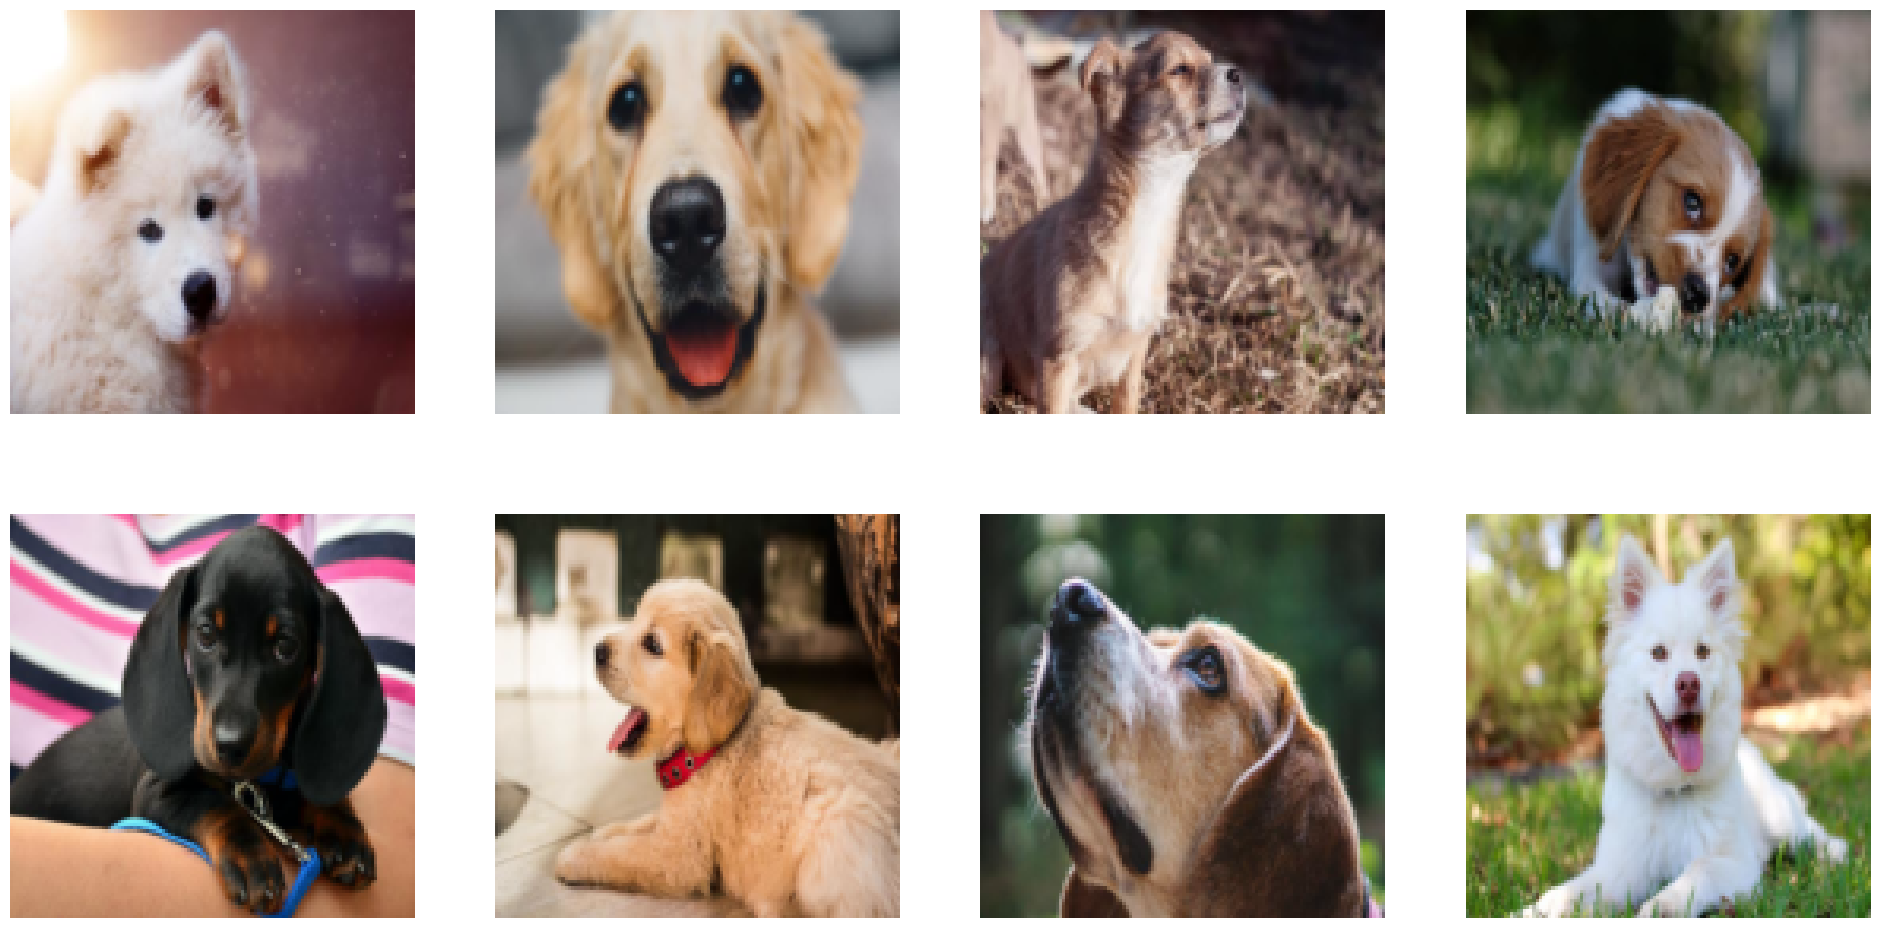

In [7]:
batch = peeked_async_batch
show_image(batch["images"])

This iterator as well as the regular DALI iterator for JAX is compatible with JAX sharding API. This allows to split the data across multiple GPUs and train the model in a distributed fashion. Decorator accepts `sharding` argument that specifies the number of shards to split the data into. The code below shows how to use the iterator with sharding:

In [8]:
import jax
from jax.sharding import Mesh, PartitionSpec, NamedSharding

mesh = Mesh(jax.devices(), axis_names=("batch"))
sharding = NamedSharding(mesh, PartitionSpec("batch"))

print(sharding)

NamedSharding(mesh=Mesh('batch': 2), spec=PartitionSpec('batch',))


In [9]:
@peekable_data_iterator(
    output_map=["images", "labels"],
    reader_name="image_reader",
    sharding=sharding,
)
def iterator_fn(num_shards=1, shard_id=0):
    jpegs, labels = fn.readers.file(
        file_root=image_dir,
        name="image_reader",
        num_shards=num_shards,
        shard_id=shard_id,
    )
    images = fn.decoders.image(jpegs, device="mixed")
    images = fn.resize(images, resize_x=128, resize_y=128)
    return images, labels.gpu()


iterator = iterator_fn(batch_size=8)

In [10]:
batch = next(iterator)

jax.debug.visualize_array_sharding(batch["images"].ravel())

  GPU 0    GPU 1  
                  

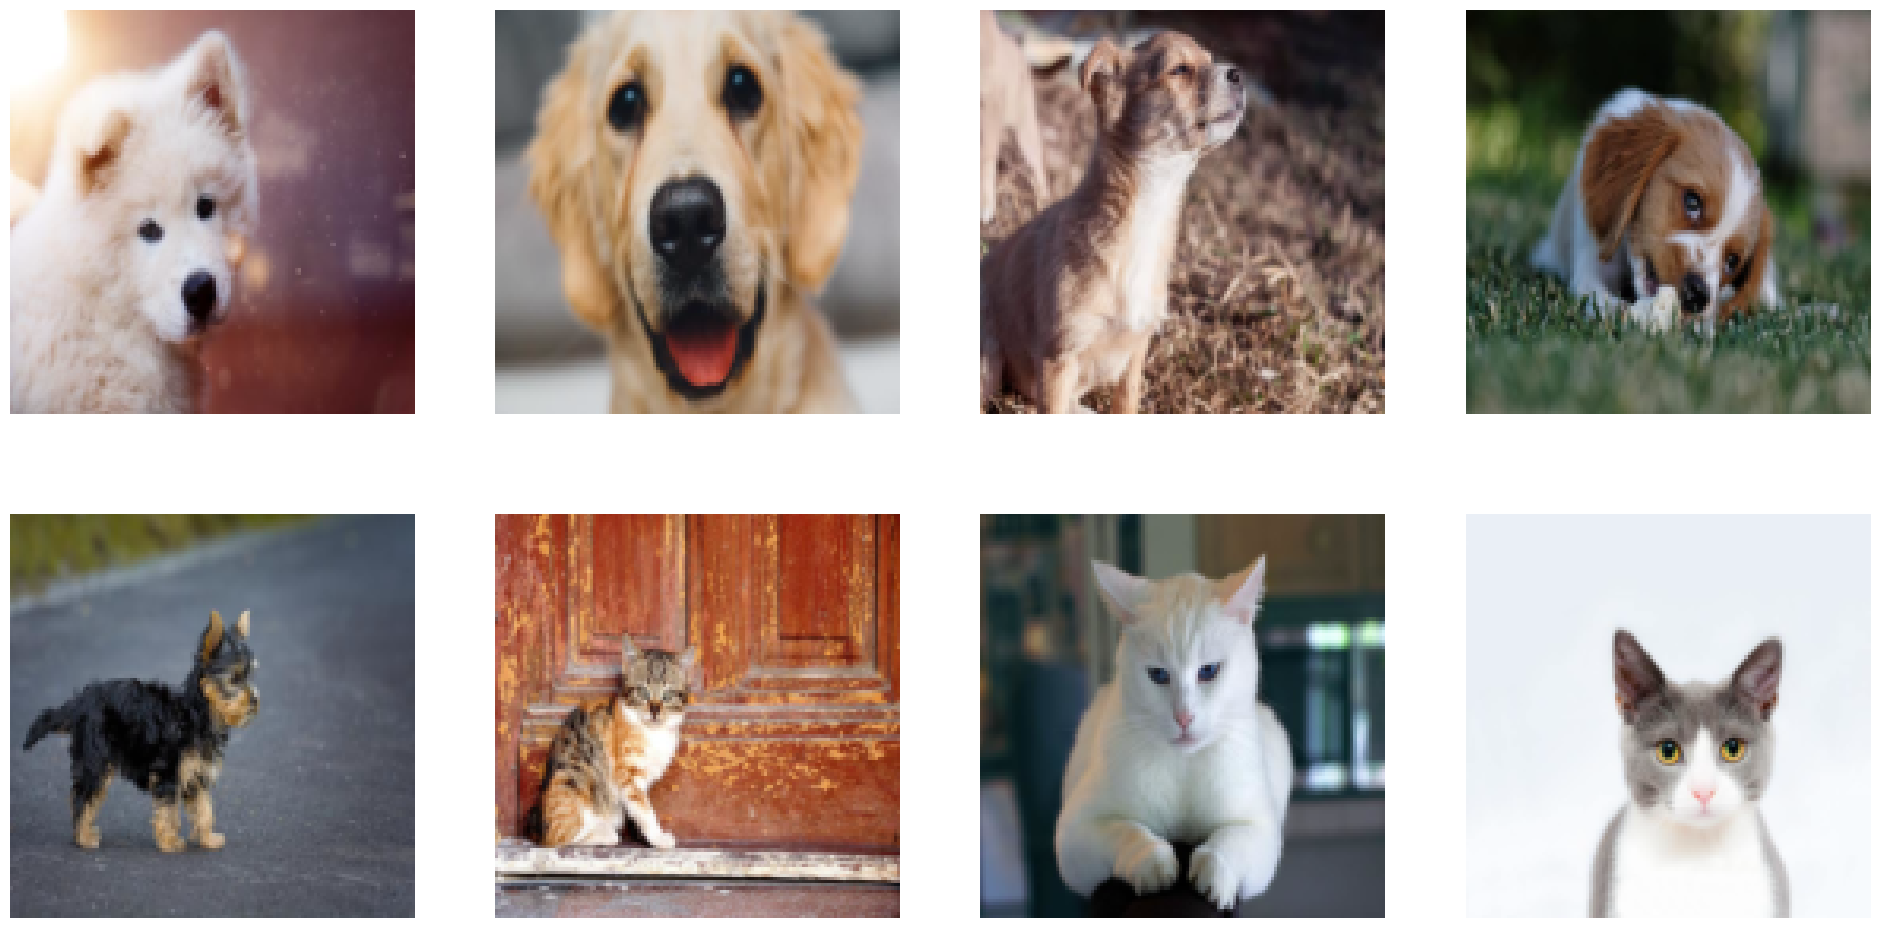

In [11]:
show_image(batch["images"])

### Where to go next

Congratulations! You have successfully completed the tutorial. Now you know how to use DALI with JAX and T5X. Here are some suggestions on where to go next:

 - to continue learning about DALI and JAX you can visit [related section of DALI documentation](https://docs.nvidia.com/deeplearning/dali/archives/dali_1_30_0/user-guide/docs/examples/frameworks/jax/index.html).
 - to see full scale example of training a model in T5X with DALI as the data source you can visit [NVIDIA JAX-Toolbox repository](https://github.com/NVIDIA/JAX-Toolbox/tree/main/rosetta/rosetta/projects/vit).